In [1]:
import os

import pyspark

conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase'
, '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', False)

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/20 11:37:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
goodreads_genres_initial = spark.read.json("shared/finals/swarali/goodreads_book_genres_initial.json")

In [3]:
goodreads_genres_initial.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- children: long (nullable = true)
 |    |-- comics, graphic: long (nullable = true)
 |    |-- fantasy, paranormal: long (nullable = true)
 |    |-- fiction: long (nullable = true)
 |    |-- history, historical fiction, biography: long (nullable = true)
 |    |-- mystery, thriller, crime: long (nullable = true)
 |    |-- non-fiction: long (nullable = true)
 |    |-- poetry: long (nullable = true)
 |    |-- romance: long (nullable = true)
 |    |-- young-adult: long (nullable = true)



In [4]:
goodreads_genres_initial.show(5, truncate = False)

+-------+---------------------------------------------------------+
|book_id|genres                                                   |
+-------+---------------------------------------------------------+
|5333265|{NULL, NULL, NULL, NULL, 1, NULL, NULL, NULL, NULL, NULL}|
|1333909|{NULL, NULL, NULL, 219, 5, NULL, NULL, NULL, NULL, NULL} |
|7327624|{NULL, NULL, 31, 8, NULL, 1, NULL, 1, NULL, NULL}        |
|6066819|{NULL, NULL, NULL, 555, NULL, 10, NULL, NULL, 23, NULL}  |
|287140 |{NULL, NULL, NULL, NULL, NULL, NULL, 3, NULL, NULL, NULL}|
+-------+---------------------------------------------------------+
only showing top 5 rows



In [5]:
from pyspark.sql.functions import expr

# Pivot the DataFrame
df_pivoted = goodreads_genres_initial.select(
    "book_id",
    expr("coalesce(genres.fiction, 0) as fiction"),
    expr("coalesce(genres.`fantasy, paranormal`, 0) as `fantasy, paranormal`"),
    expr("coalesce(genres.`young-adult`, 0) as `young-adult`"),
    expr("coalesce(genres.`history, historical fiction, biography`, 0) as `history, historical fiction, biography`"),
    expr("coalesce(genres.`mystery, thriller, crime`, 0) as `mystery, thriller, crime`"),
    expr("coalesce(genres.romance, 0) as romance"),
    expr("coalesce(genres.children, 0) as children"),
    expr("coalesce(genres.`non-fiction`, 0) as `non-fiction`"),
    expr("coalesce(genres.`comics, graphic`, 0) as `comics, graphic`"),
    expr("coalesce(genres.poetry, 0) as poetry")
)

In [6]:
df_pivoted.limit(5).toPandas()

,book_id,fiction,"fantasy, paranormal",young-adult,"history, historical fiction, biography","mystery, thriller, crime",romance,children,non-fiction,"comics, graphic",poetry
0,5333265,0,0,0,1,0,0,0,0,0,0
1,1333909,219,0,0,5,0,0,0,0,0,0
2,7327624,8,31,0,0,1,0,0,0,0,1
3,6066819,555,0,0,0,10,23,0,0,0,0
4,287140,0,0,0,0,0,0,0,3,0,0


In [7]:
from pyspark.ml.feature import VectorAssembler

feature_columns = df_pivoted.columns[1:]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df_pivoted)

In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [9]:
from pyspark.ml.clustering import KMeans

k = 10  # Set the number of clusters
kmeans = KMeans(featuresCol="scaled_features", k=k)
model = kmeans.fit(df_scaled)

In [10]:
df_clustered = model.transform(df_scaled)

In [11]:
from pyspark.sql.functions import mean, col

cluster_characteristics = df_clustered.groupBy("prediction").agg(
    mean(col("fiction")).alias("avg_fiction"),
    mean(col("fantasy, paranormal")).alias("avg_fantasy"),
    mean(col("young-adult")).alias("avg_young_adult"),
    mean(col("history, historical fiction, biography")).alias("avg_history"),
    mean(col("mystery, thriller, crime")).alias("avg_mystery"),
    mean(col("romance")).alias("avg_romance"),
    mean(col("children")).alias("avg_children"),
    mean(col("non-fiction")).alias("avg_non_fiction"),
    mean(col("comics, graphic")).alias("avg_comics"),
    mean(col("poetry")).alias("avg_poetry")
)

cluster_characteristics.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+
|prediction|       avg_fiction|       avg_fantasy|   avg_young_adult|       avg_history|       avg_mystery|       avg_romance|      avg_children|   avg_non_fiction|          avg_comics|        avg_poetry|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+
|         1| 7426.648190916089| 63.57120862201693| 9.753656658968437| 341.3556581986143|14333.611239414935| 44.05619707467282|               0.0|               0.0|                 0.0|               0.0|
|         6|4802.4926403779755| 2260.131201163002| 704.0946453449634|1244.3015930704464|120.29753467805439| 754.5000302865104|151.28263371494336| 437.8587740020595|  4.612514386092

In [12]:
cluster_characteristics.toPandas()

,prediction,avg_fiction,avg_fantasy,avg_young_adult,avg_history,avg_mystery,avg_romance,avg_children,avg_non_fiction,avg_comics,avg_poetry
0,1,7426.648191,63.571209,9.753657,341.355658,14333.611239,44.056197,0.000000,0.000000,0.000000,0.000000
1,6,4802.492640,2260.131201,704.094645,1244.301593,120.297535,754.500030,151.282634,437.858774,4.612514,6.246320
2,3,12437.671517,626.675434,1107.155008,9505.162843,7.420257,3667.675993,76.414102,2496.578064,36.316172,0.000000
3,5,10910.976331,40059.702451,10785.685545,0.000000,357.005072,72.297549,7180.791209,0.000000,0.000000,0.000000
4,9,244.380899,240.092697,74.739888,68.978652,28.178090,10.156180,28.719663,99.873034,3157.982584,0.000000
5,4,1065.444700,1286.099078,114.847926,357.928571,81.179724,45.631336,0.000000,400.281106,10451.059908,0.000000
6,8,2627.519189,2560.210545,1011.580524,275.350968,46.358501,16.958572,4385.521162,35.775825,1.404591,727.265603
7,7,6860.198162,9182.530963,13285.570515,106.330803,250.358370,3096.992809,183.947663,0.000000,0.000000,0.000000
8,2,1569.911767,204.568800,68.697065,156.933040,2814.794991,69.313796,5.806929,70.387488,0.011938,0.000000
9,0,62.182566,42.555200,15.598842,17.329311,16.885516,18.626331,8.295565,12.087427,3.793602,1.145283


In [14]:
df_clustered

DataFrame[book_id: string, fiction: bigint, fantasy, paranormal: bigint, young-adult: bigint, history, historical fiction, biography: bigint, mystery, thriller, crime: bigint, romance: bigint, children: bigint, non-fiction: bigint, comics, graphic: bigint, poetry: bigint, features: vector, scaled_features: vector, prediction: int]

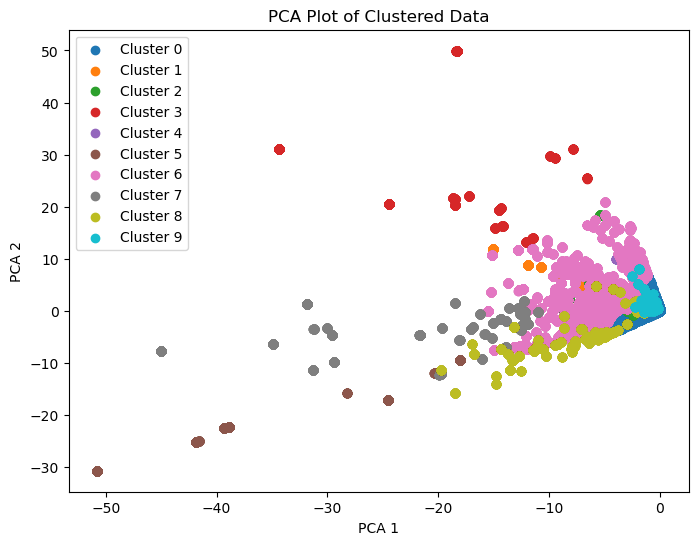

In [15]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors

# Convert the PySpark DataFrame to a Pandas DataFrame for easier visualization
df_pd = df_clustered.select("prediction", 
                            "fiction", "fantasy, paranormal", "young-adult", 
                            "history, historical fiction, biography", "mystery, thriller, crime", "romance", 
                            "children", "non-fiction", "comics, graphic", 
                            "poetry").toPandas()

# Reduce the dimensionality of the data for visualization
pca = PCAml(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
model_pca = pca.fit(df_clustered)
result_pca = model_pca.transform(df_clustered).select("prediction", "pcaFeatures")
result_pca = result_pca.toPandas()  # Convert to Pandas DataFrame for plotting

# Extract PCA features for plotting
result_pca['pca_x'] = result_pca.pcaFeatures.apply(lambda x: x[0])
result_pca['pca_y'] = result_pca.pcaFeatures.apply(lambda x: x[1])

# Plotting the results
plt.figure(figsize=(8, 6))
for i in range(0, k):
    plt.scatter(result_pca.loc[result_pca['prediction'] == i, 'pca_x'], 
                result_pca.loc[result_pca['prediction'] == i, 'pca_y'], 
                label=f'Cluster {i}')
plt.legend()
plt.title('PCA Plot of Clustered Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

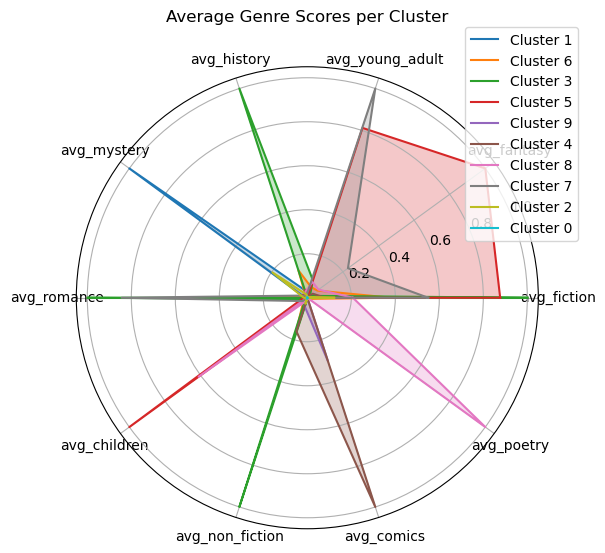

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
cluster_characteristics_pd = cluster_characteristics.toPandas()

# Normalize the data
normalized_data = cluster_characteristics_pd.set_index('prediction')
normalized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())

# Number of variables we're plotting.
num_vars = len(normalized_data.columns)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot each cluster's characteristics on the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for idx, row in normalized_data.iterrows():
    data = row.tolist()
    data += data[:1]  # Complete the loop
    ax.plot(angles, data, label='Cluster {}'.format(idx))
    ax.fill(angles, data, alpha=0.25)

# Set the labels for each axis
ax.set_xticks(angles[:-1])  # Exclude the last angle because it's a repeat of the first
ax.set_xticklabels(normalized_data.columns)

# Add a legend and title for the chart
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax.set_title('Average Genre Scores per Cluster', y=1.08)

plt.show()

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Determine the optimal number of clusters using the elbow method
wcss = []
evaluator = ClusteringEvaluator()

for k in range(5, 10):
    kmeans = KMeans(featuresCol="scaled_features", k=k)
    model = kmeans.fit(df_scaled)
    
    # Make predictions
    predictions = model.transform(df_scaled)
    
    # Evaluate clustering by computing the Within-Cluster-Sum-of-Squares (WCSS)
    silhouette = evaluator.evaluate(predictions)
    wcss.append(silhouette)


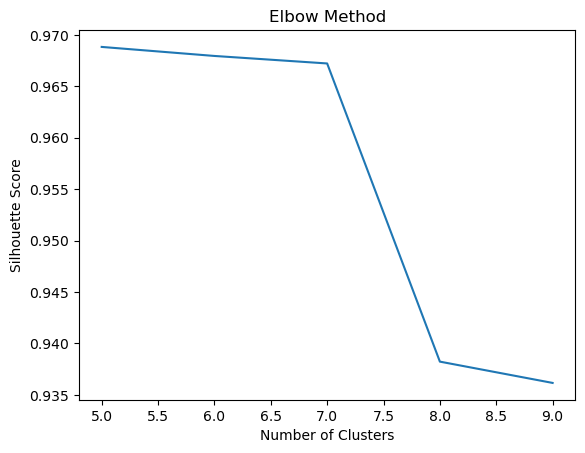

In [20]:
# Plot the elbow method
plt.plot(range(5,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [21]:
from pyspark.ml.clustering import KMeans

k = 5  # Set the number of clusters to the optimal as obtained from the silhoutte score plot
kmeans = KMeans(featuresCol="scaled_features", k=k)
model = kmeans.fit(df_scaled)

In [22]:
df_clustered_5 = model.transform(df_scaled)

In [23]:
from pyspark.sql.functions import mean, col

cluster_characteristics_5 = df_clustered_5.groupBy("prediction").agg(
    mean(col("fiction")).alias("avg_fiction"),
    mean(col("fantasy, paranormal")).alias("avg_fantasy"),
    mean(col("young-adult")).alias("avg_young_adult"),
    mean(col("history, historical fiction, biography")).alias("avg_history"),
    mean(col("mystery, thriller, crime")).alias("avg_mystery"),
    mean(col("romance")).alias("avg_romance"),
    mean(col("children")).alias("avg_children"),
    mean(col("non-fiction")).alias("avg_non_fiction"),
    mean(col("comics, graphic")).alias("avg_comics"),
    mean(col("poetry")).alias("avg_poetry")
)

In [24]:
cluster_characteristics_5.toPandas()

,prediction,avg_fiction,avg_fantasy,avg_young_adult,avg_history,avg_mystery,avg_romance,avg_children,avg_non_fiction,avg_comics,avg_poetry
0,1,5744.197025,16388.282268,4181.588862,145.850422,140.288098,46.988540,5830.698834,0.784680,1.574588,53.353639
1,3,722.027233,852.459695,138.257081,248.079521,61.410675,30.345316,9.489107,286.148148,7599.861656,0.000000
2,4,8322.090734,6689.726512,10422.445946,1093.980695,196.944337,4585.202703,11.082046,0.000000,0.000000,0.000000
3,2,6351.777873,829.867261,350.715365,2126.245808,1385.627000,516.545889,89.419465,784.447583,8.448863,158.327772
4,0,82.781622,59.772087,22.424745,20.636526,25.936247,24.277507,11.429965,12.639087,5.125047,1.254921


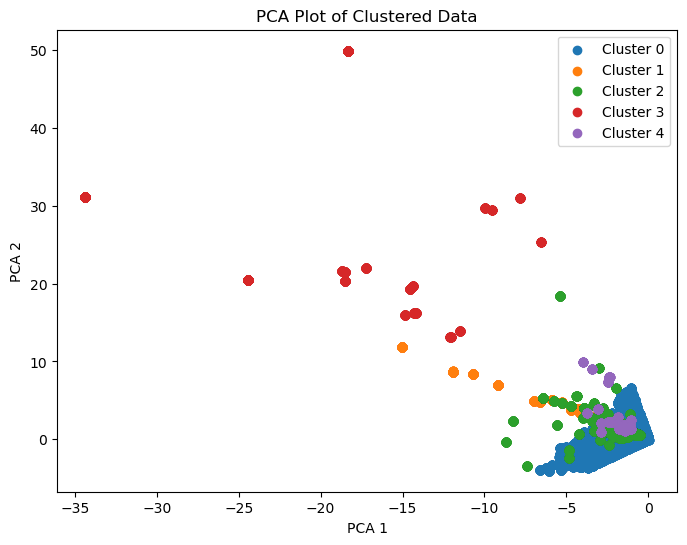

In [25]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors

# Convert the PySpark DataFrame to a Pandas DataFrame for easier visualization
df_pd = df_clustered_5.select("prediction", 
                            "fiction", "fantasy, paranormal", "young-adult", 
                            "history, historical fiction, biography", "mystery, thriller, crime", "romance", 
                            "children", "non-fiction", "comics, graphic", 
                            "poetry").toPandas()

# Reduce the dimensionality of the data for visualization
pca = PCAml(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
model_pca = pca.fit(df_clustered)
result_pca = model_pca.transform(df_clustered).select("prediction", "pcaFeatures")
result_pca = result_pca.toPandas()  # Convert to Pandas DataFrame for plotting

# Extract PCA features for plotting
result_pca['pca_x'] = result_pca.pcaFeatures.apply(lambda x: x[0])
result_pca['pca_y'] = result_pca.pcaFeatures.apply(lambda x: x[1])

# Plotting the results
plt.figure(figsize=(8, 6))
for i in range(0, k):
    plt.scatter(result_pca.loc[result_pca['prediction'] == i, 'pca_x'], 
                result_pca.loc[result_pca['prediction'] == i, 'pca_y'], 
                label=f'Cluster {i}')
plt.legend()
plt.title('PCA Plot of Clustered Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

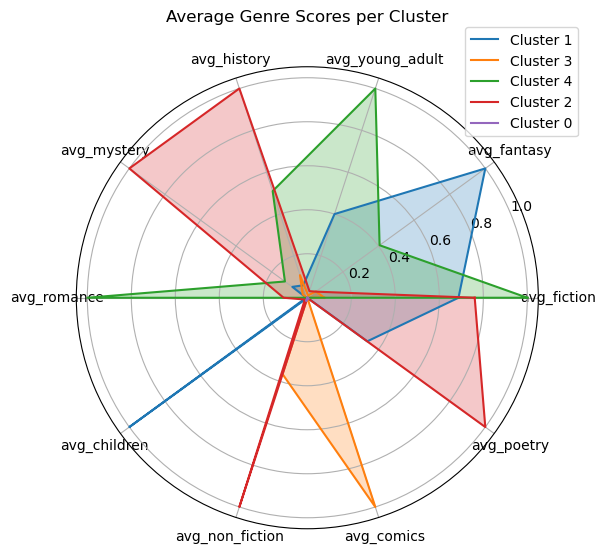

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
cluster_characteristics_pd_5 = cluster_characteristics_5.toPandas()

# Normalize the data
normalized_data = cluster_characteristics_pd_5.set_index('prediction')
normalized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())

# Number of variables we're plotting.
num_vars = len(normalized_data.columns)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot each cluster's characteristics on the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for idx, row in normalized_data.iterrows():
    data = row.tolist()
    data += data[:1]  # Complete the loop
    ax.plot(angles, data, label='Cluster {}'.format(idx))
    ax.fill(angles, data, alpha=0.25)

# Set the labels for each axis
ax.set_xticks(angles[:-1])  # Exclude the last angle because it's a repeat of the first
ax.set_xticklabels(normalized_data.columns)

# Add a legend and title for the chart
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax.set_title('Average Genre Scores per Cluster', y=1.08)

plt.show()